# Starbucks Capstone Challenge - Predicting offer effectiveness using Starbucks app data

### Project Overview

In my capstone project, I aim to answer following 2 business questions:

1. What are the main drivers of an effective offer on the Starbucks app?
2. Could the data provided, namely offer characteristics and user demographics, predict whether a user would take up an offer?


This capstone project is using data provided by Udacity as part of the Data Scientist Nanodegree course. It contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Starbucks sends out an offer to users of the mobile app. Some users might not receive any offer during certain weeks, and not all users receive the same offer.


The data provided consists of 3 datasets:

1. Offer portfolio, which consists of the attributes of each offer (portfolio.json)
2. Demographic data for each customer (profile.json)
3. Transactional records of events occurring on the app (transcript.json)

Using the data provided, I answer the above two questions using 3 classification supervised machine learning models, feeding in the data from three different offer types.

I use the model to uncover the feature importances to identify the drivers of offer effectiveness, while exploring if the model itself could be used to predict if a user would take up an offer.

Lastly, I also explore the characteristics of users who do or do not take up an offer.

I have added 2 additional models as points of exploration - the first assessing whether an all-in-one model could be used in place of 3 different models, with the offer types functioning as a categorical variable. Secondly, I also build a regression model to see if we could predict the amount a user would spend, given that the offer is effectively influencing them.



## Imports and Loading Data

In [1]:
import pandas as pd
import numpy as np
import math
import json
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report
from time import time
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
%matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## Data Exploration

### a. Offer Portfolio Data

#### portfolio.json

- id (string) - offer id
- offer_type (string) - type of offer ie BOGO, discount, informational
- difficulty (int) - minimum required spend to complete an offer
- reward (int) - reward given for completing an offer
- duration (int) -
- channels (list of strings)

Moreover, some further information given about the offers is that there are 3 different offer types:

- BOGO - buy one get one free
- Discount - discount with purchase
- Informational - provides information about products

Duration is assumed to be in number of days.

In [2]:
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [3]:
#check for any null values in the dataset
portfolio.isnull().sum()

channels      0
difficulty    0
duration      0
id            0
offer_type    0
reward        0
dtype: int64

Since no null values exist in the dataset, no need to impute any values at all.

In [4]:
#checking for number of unique offers
portfolio.id.nunique()

10

In [5]:
portfolio.groupby('offer_type')['id'].count()

offer_type
bogo             4
discount         4
informational    2
Name: id, dtype: int64

There are 10 different ids, off which 4 belong to BOGO, 4 discount and 2 for informational

#### b. Demographic Data 

Demographic data for customers is provided in the profile dataset. The schema and variables are as follows:

##### profile.json

- age (int) - age of the customer
- became_member_on (int) - date when customer created an app account
- gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
- id (str) - customer id
- income (float) - customer's income

In [6]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [7]:
#Checking for any null values in the dataset
profile.isnull().sum()

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

As suspected, the gender and income have null values. Good news is that whichever values are null in gender are also null in income.

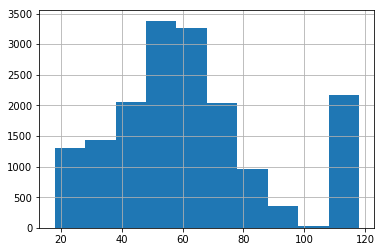

In [8]:
#checking age distribution across the users
profile.age.hist()

Age=118 isn't making any sense, as it is clearly out of the normal distribution.

In [9]:
#checking count of age=118 value and corresponding gender and income columns
print(profile[profile['age']==118].count())
profile[['gender','income','age']][profile['age']==118].head()

age                 2175
became_member_on    2175
gender                 0
id                  2175
income                 0
dtype: int64


,gender,income,age
0,None,NaN,118
2,None,NaN,118
4,None,NaN,118
6,None,NaN,118
7,None,NaN,118


As we can see above, the age=118 column corresponds with the null gender and income columns, we can drop values during preprocessing if they do not take too large a proportion of our data.

In [10]:
#checking unique people count in dataset
profile['id'].nunique()

17000

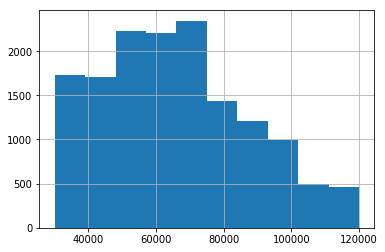

In [11]:
#check distributions of income
profile.income.hist()

became_member_on column has some potential have some major influence on whether an offer is effective or not.

In [12]:
profile.became_member_on.head()

0    20170212
1    20170715
2    20180712
3    20170509
4    20170804
Name: became_member_on, dtype: int64

#### c. Transactional Records

The schema for the transactional data is as follows:

##### transcript.json

- event (str) - record description (ie transaction, offer received, offer viewed, etc.)
- person (str) - customer id
- time (int) - time in hours. The data begins at time t=0
- value - (dict of strings) - either an offer id or transaction amount depending on the record

In [13]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [14]:
transcript.event.unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'], dtype=object)

In [15]:
#checking number of unique people represented
transcript['person'].nunique()

17000

It looks as though the number of people in transcript are the same as the number of people in the Demographics Data. But a lot of preprocessing will need to be done in order to extract meaningful insights out of this dataset.

In [16]:
#check for null values
transcript.isnull().sum()

event     0
person    0
time      0
value     0
dtype: int64

There are no null values in this data.

In order to extract insights from the value column, need expand the values into individual columns depending on the event.

In [18]:
#expanding the value column
transcript=pd.concat([transcript, transcript['value'].apply(pd.Series)], axis=1)
transcript.head()

,event,person,time,value,offer id,amount,offer_id,reward
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,NaN
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},2906b810c7d4411798c6938adc9daaa5,NaN,NaN,NaN
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,NaN
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,NaN


It appears as if the offer id column ended up being duplicates, so we need to make sure there only one offer id column

In [19]:
#creating new column to ensure only one offer_id column
transcript['offer_id_new']=np.where(transcript['offer id'].isnull() & transcript['offer_id'].notnull(),transcript['offer_id'],transcript['offer id'])

#dropping unnecessary/duplicate offer_id columns
transcript.drop(['offer id','offer_id'],axis=1,inplace=True)

#renaming offer_id column
transcript.rename(columns={'offer_id_new':'offer_id'},inplace=True)

In [20]:
transcript.head()

,event,person,time,value,amount,reward,offer_id
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},NaN,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},NaN,NaN,2906b810c7d4411798c6938adc9daaa5
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},NaN,NaN,fafdcd668e3743c1bb461111dcafc2a4
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},NaN,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0


### Defining approach for preprocessing data for the model

Before proceeding to preprocess the data for the model, let's first revisit the objectives. Having done a preliminary exploration of the data, reassing clean and prepare the data for the models intended to be build.

Firstly, need to define what an 'effective' offer is within the Starbucks app. Further exploration is done on the datasets and how all three would interact.

First, exploring what kind of events are within each offer type.

In [21]:
#renaming column
portfolio.rename(columns={'id':'offer_id'},inplace=True)

#joining transcript with offer type
transcript=transcript.merge(portfolio,how='left',on='offer_id')

In [22]:
transcript.groupby(['event','offer_type'])['offer_type'].count()

event            offer_type   
offer completed  bogo             15669
                 discount         17910
offer received   bogo             30499
                 discount         30543
                 informational    15235
offer viewed     bogo             25449
                 discount         21445
                 informational    10831
Name: offer_type, dtype: int64

We know that there are 4 types of events: offer completed, offer received, offer viewed and transaction. But our data shows that we do not have any offer_id associated with transactions, because they are not recorded in the transcript event data. Thus, the first objective in data preprocessing is to define a methodology to assign offer_ids to specific transactions.

Moreover, we also know that BOGO and discount offers have an offer completed event when offers are completed, but informational offers do not have this event associated with it. Therefore, we also specify the approach to define an effective offer as follows:

For a BOGO and discount offer, an effective offer would be defined if the following events were recorded in the right sequence in time:

offer received -> offer viewed -> transaction -> offer completed

Meanwhile, for an informational offer, since there offer completed event associated with it, I will have to define transactions as a conversion to effective offer:

offer received -> offer viewed -> transaction

## Data Preprocessing

#### a. Assigning offer ids to transactions

After defining the approach above, we now have to explore methods to assign offer_ids to specific transactions. Among the considerations is to define the following main groups of customers:

##### 1. People who are influenced and successfully convert - effective offers:

- `offer received` -> `offer viewed` -> `transaction` -> `offer completed` (BOGO/discount offers)
- `offer received` -> `offer viewed` -> `transaction` (informational offers - must be within validity period of offer)

##### 2. People who received and viewed an offer but did not successfully convert - ineffective offers:

- `offer received` -> `offer viewed`

##### 3. People who purchase/complete offers regardless of awareness of any offers:

- `transaction`
- `offer received` -> `transaction` -> `offer completed` -> `offer viewed`
- `transaction` -> `offer received` -> `offer completed` -> `offer viewed`
- `offer received` -> `transaction` -> `offer viewed` -> `offer completed`
- `offer received` -> `transaction` (informational offers)
- `offer received` -> `transaction` -> `offer viewed` (informational offers)

##### 4. People who received offers but no action taken:

- `offer received`

For people in group 2, need to check if there are events where there is an offer received and offer viewed event, but no conversion event - these are cases of ineffective offers.

Need separate out the people in group 2 from people in group 4, as people in group 2 may have viewed an offer but did not take any action, whereas people in group 4 did not even have an offer viewed event.

Separating the conversions for effective offers (group 1) and people who purchase/complete offers regardless of awareness of any offers (group 3) is particularly tricky. For people in group 3, a conversion is invalid (i.e., not a successful conversion from an offer) if an offer completed or transaction occurs before an offer viewed. There also may be scenarios where an offer completed occurs after the offer is viewed, but a transaction was done prior to the offer being viewed. In this instance, the offer may have been completed, but it is also not a valid conversion.

Defining the target variable effective offer:

After defining these conditions, need decide what the target variable will be.

We know that group 1 customers will be our target variable effective_offer=1, but there are many ineffective offer definitions for groups 2-4.

So what would we define as an ineffective offer? As already stated above, group 2 would be within our definition of an ineffective offer; where a user is aware of an offer, but the offer is ineffective as it does not convert the user into a customer. So group 2 can be defined as our target variable effective_offer=0.

What about group 3 and group 4? Group 3 consists of users who may have received offers but would have purchased regardless. From the business point of view, we would not want to be sending them any offers.

Meanwhile, group 4 users would be considered low priority customers, as they do not do any action, regardless of whether they receive offers or not.

So, we can deprioritise group 3 and group 4 users from our model. It would still be worth doing some exploratory analysis onto group 3 and 4, just to explore on their demographics.

The conditions above are the basis of which I can assign the offer id that 'influences' a transaction by ensuring that the transaction occurs after an offer viewed event.

After sorting the transcript dataset by person and time to ensure that each event for each person occurs in sequence, I can filter the dataset by events offer viewed and transaction to ensure that it only contains those events in order.

Then, I can use pandas' ffill() method to fill every transaction with the offer_id of the viewed offer, only if it occurs before the transaction.

In [23]:
#defining dropcolumns function as it will be useful later mutiple times
def drop_cols(drop_cols,df,inplace=False):
    '''
    inputs:
    - drop_cols: list columns name to be dropped
    - df: dataframe from which column should be dropped
    - inplace: specify whether columns are dropped in place or not
    
    Return:
    - dataframe with dropped columns.
       
    '''
    df=df.drop(columns=drop_cols,axis=1,inplace=inplace)
    
    return df

In [24]:
#dropping unnecessary columns to clean dataset
transcript=drop_cols(['reward_x','reward_y'],transcript)

#sorting events by person and time
transcript=transcript.sort_values(['person','time'])

In [25]:
#filtering dataset for transactions that occur after an offer is viewed, forward fill offer ids by person
offers_view_transacted = transcript[['time','offer_id','person','event']][(transcript['event']=='transaction') | (transcript['event']=='offer viewed')].groupby(['person','offer_id']).ffill()
offers_view_transacted['offer_id']=offers_view_transacted['offer_id'].ffill()

In [26]:
#creating a new dataset with the filled in offer ids for transactions
transcript=transcript.merge(offers_view_transacted,how='left',on=['person','time','event'])

In [27]:
#cleaning up dataset to unify multiple offer_id columns into one column
transcript['offer_id']=np.where(transcript['offer_id_x'].isnull(),transcript['offer_id_y'],transcript['offer_id_x'])

drop_cols(['offer_id_x','offer_id_y'],transcript,inplace=True)

In [28]:
#merging portfolio dataset again to get offer data for the transaction events
transcript = transcript.merge(portfolio,how='left',on='offer_id')
transcript['duration'] = np.where(transcript['duration_x'].isnull(),transcript['duration_y'],transcript['duration_x'])
drop_cols(['duration_x','offer_type_x','difficulty_x','channels_x','duration_y'],transcript,inplace=True);
transcript.rename(columns={'channels_y':'channels','reward_y':'reward','difficulty_y':'difficulty','offer_type_y':'offer_type'},inplace=True)

In [29]:
#final transcript data set after all the preprocessing and cleaning
transcript.head()

,event,person,time,value,amount,offer_id,channels,difficulty,offer_type,reward,duration
0,offer received,0009655768c64bdeb2e877511632db8f,168,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},NaN,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0,informational,0,3.0
1,offer viewed,0009655768c64bdeb2e877511632db8f,192,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},NaN,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0,informational,0,3.0
2,transaction,0009655768c64bdeb2e877511632db8f,228,{'amount': 22.16},22.16,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0,informational,0,3.0
3,offer received,0009655768c64bdeb2e877511632db8f,336,{'offer id': '3f207df678b143eea3cee63160fa8bed'},NaN,3f207df678b143eea3cee63160fa8bed,"[web, email, mobile]",0,informational,0,4.0
4,offer viewed,0009655768c64bdeb2e877511632db8f,372,{'offer id': '3f207df678b143eea3cee63160fa8bed'},NaN,3f207df678b143eea3cee63160fa8bed,"[web, email, mobile]",0,informational,0,4.0


### b. Flagging transactions and offers completed after offers viewed

The next important step for preparing our data for modeling and analysis is to identify a completed offer and transactions occurring after an offer is viewed.

Once we have assigned a transaction occurring after an offer is viewed, we can use that information to subset my data according to the groups defined above, and analyse within each group.

Using our re-engineered dataset with the offer_ids populated for transaction events, we can flag the converted transactions and completed offers. We have to first ensure that the offer id of the previous event is the same one. Since we have tagged the offer id for all viewed, transactions and completed offers, we can use the offer_id field to ensure that the previous offer consists of those events.

To do this, created a new column to flag the previous offer id using pandas' shift function.

In [30]:
#retrieving sample space of events consisting of offer viewed, transactions and offer completed
offers_viewed_transactions_completed=transcript[(transcript['event']=='offer viewed') | (transcript['event']=='transaction') | (transcript['event']=='offer completed')].copy()

In [31]:
#adding extra column to flag the previous offer id
offers_viewed_transactions_completed['offer_id_previous'] = offers_viewed_transactions_completed.groupby(['person','offer_id'])['offer_id'].shift()

In [32]:
#flagging a completed transaction/offer completed as long as the previous offer id consists of events in the same sample space
offers_viewed_transactions_completed['valid_completed']=np.where(offers_viewed_transactions_completed['offer_id_previous']==offers_viewed_transactions_completed['offer_id'],1,0)

Since our dataset offers_viewed_transactions_completed consists of all other possible events, need to append all offers received events in the transactions_clean dataset to ensure we have our complete dataset again.

In [34]:
#get only offer received events
offers_received = transcript[transcript['event']=='offer received'].copy()

#ensure all columns are the same between datasets to be appended
offers_received['offer_id_previous'] = np.nan
offers_received['valid_completed'] = np.nan

#appendding  datasets to complete dataset of transactions
transcript = offers_received.append(offers_viewed_transactions_completed)

#sort values
transcript = transcript.sort_values(['person','time'])

Having assigned offer_ids for transactions for which an offer viewed event occurred prior, we can now revisit the four customer groups of unique person-offer_id pairs we are trying to analyse.

In [35]:
#defining function to split into 3 offer types
def split(offer_type,grp_df):
    '''
    Splits dataframe to groups of specified offer type.
    
    inputs:
    - offer_type: specifying offer type name in string format 
    - grp_df: original transcript dataframe to split on offer type
    
    outputs:
    - Returns dataframe containing data of just offer type.
       
    '''
    df=grp_df[grp_df['offer_type']==offer_type].copy()
    
    return df

#split transcript into 3 different offer types
transcript_bogo = split('bogo',transcript)
transcript_discount = split('discount',transcript)
transcript_info = split('informational',transcript)

Within each offer type, we can already successfully separate every unique person-offer_id in group 1 from the others using our valid_completed column. Since already flagged all conversion events (transaction or offer completed event depending on offer type) occurring after an offer viewed event, we can be assured that whichever conversion events are flagged with valid_completed=1 are at least within the first group (People who are influenced and successfully convert - effective offers).

For BOGO and discount offers, we will only consider offer completed events as the conversion events, while we can consider transaction event as the conversion event for the informational offers.

In [36]:
#since will do this for both BOGO and discount, define function for repeated operation
def grp1(df):
    '''
    Subsets dataframe to just group 1 members.
    
    inputs:
    - df: original transcript dataframe 

    returns:
    - dataframe containing transcript data of just group 1 users.
       
    '''
    grp1 = df[['person','offer_id']][(df['valid_completed']==1) & (df['event']=='offer completed')].groupby(['person','offer_id']).count().reset_index()
    return grp1

grp1_bogo = grp1(transcript_bogo)
grp1_discount = grp1(transcript_discount)

For informational offers will define group 1 later as there is an additional consideration we need to take into account for transactions - they need to occur within the validity period of an informational offer for us to consider them as effective offers.

Now, we can look into separating group 2 and group 4 unique person-offer_ids for BOGO and discount offers as we just need to look at the subset of people with offer received, offer viewed, but no conversion events. We can also assume that every person who views an offer would have had an offer received event prior, so we can just take the whole group of people who received an offer and subset them later.

In [37]:
#defining a function as we will repeat this for 2 datasets - BOGO & discount
def no_conv(df):
    
    '''
    Takes in transcript dataframe of single offer type to check for people who converted vs people with just offer received events. 
    
    inputs:
    - df: original transcript dataframe of specific offer type 
    
    returns:
    - dataframe containing unqiue person-offer_id pairs with conversion events and offers received events, with indicator of each.
    
    Note: left_only indicator is just the offers received events, right_only is just conversion events
       
    '''
    
    #subset offer ids that have transactions or conversions by person and offer_id
    conversion_ids = df[['person','offer_id']][(df['event'] == 'transaction') | (df['event'] == 'offer completed') ].groupby(['person','offer_id']).count().reset_index()

    #check for unique person-offer_id pairs that consist of offers received 
    offers_received_only = df[['person','offer_id']][df['event'] == 'offer received'].groupby(['person','offer_id']).count().reset_index()

    #create merged dataset to diffrentiate groups
    check_merge = conversion_ids.merge(offers_received_only,how = 'right',on = ['person','offer_id'],indicator = True)
    return check_merge

#checking how many are in either group
check_merge_bogo = no_conv(transcript_bogo)
print('For BOGO offers:')
print(check_merge_bogo.groupby(['_merge']).count())

check_merge_discount = no_conv(transcript_discount)
print('For Discount offers:')
print(check_merge_discount.groupby(['_merge']).count())

For BOGO offers:
            person  offer_id
_merge                      
left_only        0         0
right_only    4729      4729
both         20592     20592
For Discount offers:
            person  offer_id
_merge                      
left_only        0         0
right_only    6415      6415
both         18901     18901


There are definitely a fair number of unique person-offer_id pairs that have offer received events, but no conversion events. These to be considered group 2 and 4 within each offer type.

People with an offer viewed event in this subset are definitely in group 2, as we can assume everyone with an offer viewed event has an offer received event prior.

In [38]:
#grouping for groups 2 & 4 function as will repeat this for BOGO and discount offers
def grp_2_4(df):
    
    '''
    Takes in output dataframe from no_conv function to split into group 2 and 4 customers.
    
    inputs:
    - df: output dataframe from no_conv function
    
    returns:
    -2 dataframes containing unique person-offer_id pairs with dataframe containing only group2 customers first, followed by dataframe containing only group 4 customers.   
    '''
    
    #subset to check group 2 and 4
    grp_2_4 = df[df['_merge'] == 'right_only']

    #remerge with transcript to get events
    grp_2_4 = grp_2_4.merge(transcript,how = 'left',on = ['person','offer_id'])

    #separate people with offer viewed event, and people with offer received but no offer viewed
    grp2 = grp_2_4[['person','offer_id']][grp_2_4['event'] == 'offer viewed'].groupby(['person','offer_id']).count().reset_index()
    
    #merge with full dataset and get remaining to get grp4
    drop_cols('_merge',grp_2_4,inplace = True)
    grp4 = grp_2_4.merge(grp2[['person','offer_id']],how = 'left',indicator = True)
    grp4 = grp4[grp4['_merge'] == 'left_only'].copy()
    
    return grp2,grp4

grp2_bogo,grp4_bogo = grp_2_4(check_merge_bogo)
grp2_discount,grp4_discount = grp_2_4(check_merge_discount)

Group 3 people are everyone in the converted ids who do not have an offer viewed prior - hence, they would be people with conversion events but no offer viewed event prior. For BOGO and discount offers, they would be people with offer completed events that have valid_completed != 1.

In [39]:
#defining for group 3
def grp3(df):
    '''
    Takes in transcript dataframe of single offer type to check for people who converted vs people with just offer received events. 
    
    inputs:
    - df: original transcript dataframe of specific offer type 
    
    returns:
    - dataframe containing unqiue person-offer_id pairs with conversion events and offers received events, with indicator of each.  
    '''
    
    #check all conversion events with invalid conversions
    grp3 = df[['person','offer_id']][(df['event'] == 'offer completed') & (df['valid_completed'] != 1)].groupby(['person','offer_id']).count().reset_index()
    return grp3

grp3_bogo = grp3(transcript_bogo)
grp3_discount = grp3(transcript_discount)

After split our data into 4 different customer groups for the BOGO and discount offers, we  consider the effective and ineffective offers depending on the group type. As stated above, any unique person-offer_id belonging to group 1 can be considered in our target variable effective_offer=1 group.

Meanwhile, group 2 is in our target variable effective_offer=0 group. For customers in groups 3 and 4, deprioritiseing them for model implementation, but will be doing some exploratory analysis on them later.

In [40]:
#defining offeres dunction with labeled effectiveness for the offers
def offers(grp1,grp2):
    '''
    inputs:
    - grp1: dataframe containing group1 customer data 
    - grp2: dataframe containing group2 customer data
    
    returns:
    - dataframe with labeled effective offer column
    '''
    
    #assigning effective offer flag column
    grp1['effective_offer'] = 1
    grp2['effective_offer'] = 0

    #appending datasets together
    offers = grp1.append(grp2,sort = False)
    return offers

offers_bogo = offers(grp1_bogo,grp2_bogo)
offers_discount = offers(grp1_discount,grp2_discount)

Now we have successfully prepared the target variables for our BOGO and discount datasets.

Before we tag the effective offers column, there is one more consideration - the validity of the offer.

### c. Considering duration/validity of offers in converted transactions from informational offers

There is an additional rule to consider when considering an effective/converted transaction and offer. This applies for offers that are of type 'informational'. The reason why informational offers get a different treatment is because the conversion event is not an offer completed event, but a transaction.

For informational offers, the duration of the offer can be considered to be the duration of the influence. Hence, assuming that an offer should only be considered effective if it is within the duration of the offer.

Meanwhile, for BOGO and discount offers, assume that if there is a conversion/ offer completed event, it should be within duration as it would not make sense for an offer to be completed if an offer is past its validity period.

As we saw in our data dictionary, the time of an event in the transcript data is in terms of hours. In order to ensure it is on the same scale as the duration of the offer, we have to convert it into days.

In [41]:
#converting time into days
transcript_info['day_offer'] = transcript_info['time']/24

#dropping unnecessary columns
drop_cols(['time','value','offer_id_previous'],transcript_info,inplace=True)

In [42]:
#sorting transactions to ensure all events occurring by person and offer
transcript_info = transcript_info.sort_values(['person','day_offer','event','offer_id'])

We can get the difference between two events using the diff function in pandas. We take the difference between the transaction and the offer received as the duration.

In [43]:
#get difference in time for informational offers
transcript_info['diff_info'] = transcript_info[(transcript_info['offer_type'] == 'informational') & ((transcript_info['event'] == 'offer received') | (transcript_info['event'] == 'transaction'))].groupby(['person','offer_id'])['day_offer'].diff()

In [44]:
#creating column for flagging valid events
transcript_info['valid_completed_duration'] = np.nan

#flagging valid events if within duration
transcript_info.loc[transcript_info['diff_info'] <= transcript_info['duration'],'valid_completed_duration'] = 1

#filling any missing values with 0 flag
transcript_info['valid_completed_duration'] = transcript_info['valid_completed_duration'].fillna(value = 0)

Scenario 1: completed transaction after offer viewed event, but not within duration <br/>
Scenario 2: completed transaction within duration, but with no offer viewed event prior <br/> 
Scenario 3: completed transaction within duration, with offer viewed event - an effective offer <br/>
Scenario 4: did not complete transaction within duration, no offer viewed event prior 

Meanwhile, Scenarios 1 and 2 can be considered to be actions that would put the customer into our Group 3 of customers - People who purchase/complete offers regardless of awareness of any offers.

For customers in Scenario 1, even though according to our valid_completed flag, they had viewed an offer prior to the transaction, but it is not within the duration, thus they are not 'influenced' by the offer.

Meanwhile for customers in Scenario 2, they are in Group 3 as they completed transactions without viewing an offer.

Scenario 4 can be considered in group 4, as they only consist of transactions.

We will need to separate those users in group 2 - those who may have received and viewed an offer, but no transactions after. We need to subset those where effective_offer!=1 into groups 2,3 and 4.

In [45]:
#flag effective_offers where valid_completed=1 and valid_completed_duration=1
transcript_info['effective_offer'] = np.where(((transcript_info['valid_completed'] == 1) & (transcript_info['valid_completed_duration'] == 1)),1,0)

After flagging our effective offers, we can subset them into the 4 groups already outlined above. We can also filter this only for the effective offers=1 events, as we only want the effective transactions influenced by an offer, not other transactions.

In [47]:
#separate group 1 in transcript_into
grp1_info = transcript_info[['person','offer_id']][transcript_info['effective_offer']==1].groupby(['person','offer_id']).sum().reset_index()

From the remaining people, we have to separate it out into groups 2 and 4. We can use similar steps to what we did with BOGO and Discount offers, since we don't have the duration consideration.

In [48]:
#separating out group 2 of customers
check_merge_info = no_conv(transcript_info)
print('For informational offers:')
print(check_merge_info.groupby(['_merge']).count())

For informational offers:
            person  offer_id
_merge                      
left_only        0         0
right_only    5412      5412
both          7239      7239


In [50]:
grp2_info,grp4_info = grp_2_4(check_merge_info)

In [51]:
#scenario 1
grp3_1 = transcript_info[['person','offer_id']][(transcript_info['event'] == 'transaction') & (transcript_info['valid_completed'] != 1) & (transcript_info['valid_completed_duration'] == 1)].groupby(['person','offer_id']).count().reset_index()

#scenario 2
grp3_2 = transcript_info[['person','offer_id']][(transcript_info['event'] == 'transaction') & (transcript_info['valid_completed'] == 1) & (transcript_info['valid_completed_duration'] != 1)].groupby(['person','offer_id']).count().reset_index()
grp3_info = grp3_1.append(grp3_2,sort = False)

del grp3_1
del grp3_2

Now we can append the datasets together to make the offers_info dataset, ready for modeling.

In [52]:
offers_info = offers(grp1_info,grp2_info)

Now that we have subset all our datasets into effective and ineffective offers depending on offer type, we can append the datasets accordingly into datasets for modeling.

### d. Feature engineering

Now we have to look back had to look into the features and see how to be creative in creating new features.

#### d.i. became_member_on column to be engineered

Recalling preliminary data exploration steps, the became_member_on column were in date format. Hence in order to extract meaningful insights from that feature, converting it as a feature indicating tenure of membership. There could be some influence in how long someone has been a member, with whether he takes up an offer.

In [53]:
#renaming column for merging
profile.rename(columns = {'id':'person'},inplace = True)

#creating function to reuse 3 datasets
def member(df):
    '''
    inputs:
    - df: original dataframe to transform became_member_on column  
    
    returns:
    - dataframe with became_member_on column transformed to be tenure in days    
    '''
    
    #merging to get user demographic profile
    df=df.merge(profile,how='left',on='person')
    
    #converting became_member_on into member tenure
    df['year'] = pd.Series([int(str(x)[:4]) for x in df['became_member_on']])
    df['month'] = pd.Series([int(str(x)[-3]) for x in df['became_member_on']])
    df['day'] = pd.Series([int(str(x)[-2:]) for x in df['became_member_on']])
    df = drop_cols('became_member_on',df)
    df.loc[df['year'] == 2018, 'membership_tenure_days'] = (30*df['month'])+df['day']
    df.loc[df['year'] != 2018, 'membership_tenure_days'] = ((2018-df['year'])*365)+(30*df['month'])+df['day']
    df = drop_cols(['year','month','day'],df)
    
    return df

offers_bogo=member(offers_bogo)
offers_discount=member(offers_discount)
offers_info=member(offers_info)


#### d.ii. Count of offers received

As part of some further data exploration, I discovered that there could be multiple offers received per person.

person
0009655768c64bdeb2e877511632db8f    5
00116118485d4dfda04fdbaba9a87b5c    2
0011e0d4e6b944f998e987f904e8c1e5    5
0020c2b971eb4e9188eac86d93036a77    5
0020ccbbb6d84e358d3414a3ff76cffd    4
Name: event, dtype: int64


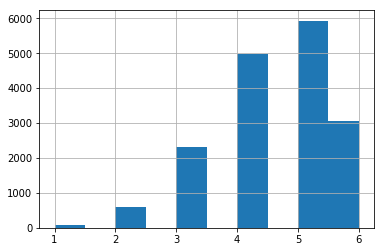

In [54]:
#grouping event=offer received per person in transactional records
print(transcript[transcript['event']=='offer received'].groupby('person')['event'].count().head())

#visualise offers received per person
transcript[transcript['event']=='offer received'].groupby('person')['event'].count().hist()

On the basis of the hypothesis that the frequency of offers received per person might result in more effective offers, so decided to engineer a feature offer_received_cnt to account for this frequency.

In [55]:
#get count of offers received per person, put into separate dataset
df_offer_received_cnt = transcript[transcript['event'] == 'offer received'].groupby(['person','offer_id','time']).count()['event'].reset_index()

#rename columns
df_offer_received_cnt.rename(columns = {'event':'offer_received_cnt'},inplace=True)

#drop unnecessary columns
drop_cols('time',df_offer_received_cnt,inplace = True)
 
#ensure only unique person-offer_id pairs
df_offer_received_cnt = df_offer_received_cnt.groupby(['person','offer_id']).sum().reset_index()

#### d.ii. Separating user behaviours by transactions

How many transactions would be considered 'invalid' due to defined definitions. Ordinarily, these would be the sum of transactions done by people not in group 1. The objective of offers are to drive purchases, so it would already be the case that users with high spend in their transactions would be flagged as effective_offers.

For users in group 1 have a high amount of 'invalid spend' outside of the effect of offers, there might be some predictive power onto the effectiveness of offers; since a loyal user might have a higher tendency of taking up an offer.

In datasets, we have already separated the transactions who are conversions versus transactions who are just the users' normal purchasing behaviour. This is through the valid_completed column, where we checked if a transaction had an offer viewed event prior.

In the cases where valid_completed=1, I had already included them in my effective offers flag for BOGO and Discount offers. However, for those transctions where valid_completed=0, I have not considered them, and this could be a potential feature to include, as a proxy for the 'baseline' level of spending for a user.

Basis: if there is some baseline level of spending for users who are highly influenced by certain offers (in group 1), and group 2, and if there is some predictive power in this baseline level of 'invalid transactions' that can predict the propensity of a user to take up an offer.

In [56]:
#filtering dataset by invalid transactions
df_transactions_invalid = transcript[(transcript['event'] == 'transaction') & (transcript['valid_completed'] == 0)].groupby(['person','offer_id'])['amount'].sum().reset_index()
df_transactions_invalid.rename(columns = {'amount':'amount_invalid'},inplace = True)

#### d. iii. Time elapsed between offers received

To include time as a potential feature into my dataset, but since the transactional data starts from time=0, it would not have been of much predictive power without some feature engineering. What if there were multiple offers received per person within a certain time period, there might be some predictive power in the time elapsed between offers received.

In [57]:
#convert time into days
transcript['day_offer'] = transcript['time']/24
#drop unnecessary columns
drop_cols(['time'],transcript,inplace = True);

#find time elapsed between offers received
transcript['time_elapsed_offers'] = transcript[transcript['event'] == 'offer received'].groupby(['person','offer_id'])['day_offer'].diff()

#fill missing values with 0, as if someone does not receive an offer or is receiving an offer for the first time, there is no time elapsed
transcript['time_elapsed_offers'] = transcript['time_elapsed_offers'].fillna(value=0)

#create temporary dataset
df_time_elapsed = transcript.groupby(['person','offer_id'])['time_elapsed_offers'].sum().reset_index()

### e. Preparing data for implementation

Now we can finally begin with preparing the data for modeling.

To do this, there are some additional preparation steps for each dataset. Recalling our initial preliminary data exploration, there are some steps to prepare the data:

a. Merge with temporary datasets created above to include engineered features

b. Drop missing values in gender column for demographic data; convert gender into dummy variables

c. Separate the channel column into categorical variables

d. Treatment of duplicate records

#### e.a. Merge with temporary datasets created above to include engineered features

In [58]:
#merging to get offers received count and invalid amount transacted 
offers_bogo = offers_bogo.merge(df_offer_received_cnt[['person','offer_id','offer_received_cnt']],how = 'left',on = ['person','offer_id'])
offers_bogo = offers_bogo.merge(df_transactions_invalid[['person','offer_id','amount_invalid']],how = 'left',on = ['person','offer_id'])

#### e.b Dropping missing values in gender column for demographic data

Need to check whether dropping the missing values will result in a significant loss in data.

In [59]:
#check % of missing values in dataset
(offers_bogo.isnull().sum()/len(offers_bogo)*100).sort_values(ascending=False).head()


amount_invalid            96.323752
income                     7.057489
gender                     7.057489
offer_received_cnt         0.000000
membership_tenure_days     0.000000
dtype: float64

We can see that the missing values are quite extensive especially for the amount_invalid column. It is debatable whether this column amount_invalid would be useful to include in the model. Plan is to assess this feature again later during the model implementation phase. For now, I decided to fill the missing amount_invalid column with 0 as it could represent that only 3% of the overall users tend to purchase without offers.

In [60]:
#fill missing values for amount_invalid with 0
offers_bogo['amount_invalid']=offers_bogo['amount_invalid'].fillna(value=0)

#drop income and gender null rows
offers_bogo.dropna(inplace=True)

#### e.c Factoring channel column into categorical variables

In [61]:
#Creating reuse function for reuse, as we have already used this multiple times
def rename(col_name,df):
    df[col_name]=np.where(df[col_name]==col_name,1,0)
    return df

#foresee need to reuse dummy variable encoding function
def dummy(df,col):
    df=pd.concat([df[:],pd.get_dummies(df[col],prefix=col)],axis=1)
    df=drop_cols(col,df)
    return df

In [62]:
#merging with portfolio to get offer details
offers_bogo = offers_bogo.merge(portfolio,how = 'left', on = 'offer_id')

#converting channels into categorical variables
channels = offers_bogo['channels'].apply(pd.Series)
channels = channels.rename(columns = {0:'web',1:'email',2:'mobile',3:'social'})
offers_bogo = pd.concat([offers_bogo[:], channels[:]], axis = 1)
rename('web',offers_bogo)
rename('email',offers_bogo)
rename('mobile',offers_bogo)
rename('social',offers_bogo)
offers_bogo = drop_cols('channels',offers_bogo)

#convert gender into categorical variables
offers_bogo = dummy(offers_bogo,'gender')

In [63]:
#Since we need to repeat these steps for offers_discount, creating a function containing all the steps above.
def prep_offers_df(df):
    
    '''
    inputs:
    - df: original dataframe for modeling 
    
    Returns:
    - dataframe containing engineered features, filled missing values and cleaned and transformed variables (channel and gender)       
    '''
    #merge to get engineered features 
    df = df.merge(df_offer_received_cnt[['person','offer_id','offer_received_cnt']],how = 'left',on = ['person','offer_id'])
    df = df.merge(df_transactions_invalid[['person','offer_id','amount_invalid']],how = 'left',on = ['person','offer_id'])
    
    #fill missing values for amount_invalid with 0
    df['amount_invalid'] = df['amount_invalid'].fillna(value=0)
    
    #drop income and gender null rows
    df.dropna(inplace = True);
    
    #merge with portfolio to get offer details
    df = df.merge(portfolio,how ='left',on ='offer_id')

    #convert channels into categorical variables
    channels = df['channels'].apply(pd.Series)
    channels = channels.rename(columns={0:'web',1:'email',2:'mobile',3:'social'})
    df = pd.concat([df[:], channels[:]], axis=1)
    rename('web',df)
    rename('email',df)
    rename('mobile',df)
    rename('social',df)
    df = drop_cols('channels',df)
    
    #convert gender column into dummy variables
    df = dummy(df,'gender')

    return df

In [64]:
#preparing data for offer_discounts
offers_discount = prep_offers_df(offers_discount)

In [65]:
#merging with portfolio to get offer details
offers_info = offers_info.merge(portfolio,how = 'left',on = 'offer_id')

#reset index for offers_info
offers_info = drop_cols('index',offers_info.reset_index())

#expand channel column into categorical variables
def channel_col(name,df=offers_info):
    '''
    inputs:
    - name: name of channel column to be transformed 
    - df: dataframe 
    
    returns:
    - offer_info dataframe with channel column transformed
    
    '''
    df[name] = np.nan
    df.loc[pd.Series([name in df['channels'][x] for x in range(len(df['channels']))]),name]=1
    df[name] = df[name].fillna(value=0)

    return df

In [66]:
channel_col('web')
channel_col('email')
channel_col('mobile')
channel_col('social');

drop_cols('channels',offers_info,inplace=True)

In [67]:
#repurposing function for offers_info
def prep_offers_df(df):
    '''
    inputs:
    - df: dataframe to be transformed 
    
    returns:
    - dataframe with engineered features and filled missing values, with transformed gender column.
       
    '''
    #merge to get engineered features 
    df = df.merge(df_offer_received_cnt[['person','offer_id','offer_received_cnt']],how='left',on=['person','offer_id'])
    df = df.merge(df_transactions_invalid[['person','offer_id','amount_invalid']],how='left',on=['person','offer_id'])

    #fill missing values for amount_invalid and offer_received_cnt with 0
    df['amount_invalid'] = df['amount_invalid'].fillna(value=0)

    #drop income and gender null rows
    df.dropna(inplace = True);
    
    #convert gender column into dummy variables
    df = dummy(df,'gender')

    return df

In [68]:
offers_info = prep_offers_df(offers_info)

In [69]:
offers_info.head()

,person,offer_id,effective_offer,age,income,membership_tenure_days,difficulty,duration,offer_type,reward,web,email,mobile,social,offer_received_cnt,amount_invalid,gender_F,gender_M,gender_O
0,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,1,33,72000.0,506.0,0,4,informational,0,1.0,1.0,1.0,0.0,1.0,0.00,0,1,0
1,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,1,33,72000.0,506.0,0,3,informational,0,0.0,1.0,1.0,1.0,1.0,0.00,0,1,0
2,0020c2b971eb4e9188eac86d93036a77,5a8bc65990b245e5a138643cd4eb9837,1,59,90000.0,824.0,0,3,informational,0,0.0,1.0,1.0,1.0,1.0,0.00,1,0,0
3,0020ccbbb6d84e358d3414a3ff76cffd,5a8bc65990b245e5a138643cd4eb9837,1,24,60000.0,771.0,0,3,informational,0,0.0,1.0,1.0,1.0,1.0,16.27,1,0,0
4,003d66b6608740288d6cc97a6903f4f0,3f207df678b143eea3cee63160fa8bed,1,26,73000.0,566.0,0,4,informational,0,1.0,1.0,1.0,0.0,1.0,0.00,1,0,0


#### e.d Treatment of duplicate records

Since we have subset the data cleanly according to unique person-offer_id pairs by group, we should not have any duplicate records. But just in case, we check to make sure we have no duplicate records.